In [1]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.quantum_info.operators import Operator



def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

In [2]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction


def get_qubit_op(coordinates):

    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0], 0.0, 0.0] ],
            ["H", [coordinates[1], 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm',shots=256):

    
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        quantum_instance = QuantumInstance(backend, shots=shots)
        optimizer = SPSA(maxiter=100)
    elif simulator == 'exact':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = SLSQP(maxiter=5)
    else:
        print('Error: simulator should be qasm or exact!')
 
    result = exact_solver(problem,converter)

    init_state = HartreeFock(num_orb, num_part, converter)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(op)
    min_eng = vqe_result.eigenvalue
    final_params = vqe_result.optimal_parameters 
    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    return vqe_ground, min_eng

In [48]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 # in Angstrom

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli


def get_psi_0(coordinates, simulator='qasm', shots=256):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator, shots)
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm', shots=256):
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator, shots)
        
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == 'exact':
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    #loop over particles
    
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
       
        #get the expectation value ¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0) 
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        f = sampler.eval().real + rep_eng_plus - rep_eng_minus
        
        forces.append(f*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliArray= np.array([]), shots=256):
    ''' Calculates the force and covariance matrix at given coordinates, and an array of all
    Pauli operators that are in the support of the relevant observables, denoted as pauli_op_array 
    inside of the function. Once this support has been calculated, it can be reused, and thus one can also 
    pass it as argument, denoted PauliArray.
    '''

    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == 'exact':
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)    
    psi_0 = get_psi_0(coordinates, simulator=simulator, shots=shots)

    forces = np.zeros(num_coord)
    force_ops = []
    force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
    
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
    for i in range(num_coord):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])

        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I)
        
       
        op = (qubit_op_minus - qubit_op_plus).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
                
        force_ops.append(op)
        force_op_coeffs.append(op_list)
        
        if i == 0:  #we need two Pauli Ops to calculate the product and their support
            P1 = op
    
   
    if PauliArray.size == 0:
        
        pauli_op_set = {'II'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for (PauliString,coeff) in force_op_coeffs[0]:
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
            P_prod = (P1@P1).reduce()
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
        pauli_op_array = np.array(list(pauli_op_set))
                
    else: pauli_op_array = PauliArray
        
    
    # Now we calculate the expectation values of all the relevant PauliOps
    
    exp_dict = {} # dictionary with relevant expectation values
    
    for pauli_string in pauli_op_array:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        
        exp_dict[pauli_string] = E
            
    for i in range(len(coordinates)):
        for (pauli_op,coeff) in force_op_coeffs[i]:
                forces[i] += coeff.real*exp_dict[pauli_op]
                
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
    COV_diag = np.zeros((num_coord,num_coord)) #only diagonal terms. 
    
    for i in range(num_coord):
        for j in range(i,num_coord):
            Pij = (force_ops[i]@force_ops[j]).reduce()
            Pij_list = Pij.primitive.to_list()
            
            #add product expectation 
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
            #subtract 
            COV[i,j] -= forces[i]*forces[j]
            
            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j] 
        COV_diag[i,i] = COV[i,i]
  
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2,pauli_op_array, COV_diag*(Ha*(1/(2*dR*angst)))**2

In [5]:
# microcanonical
from tqdm import tqdm #to show progress

#implementation of the simple Verlet integrator
femto = 1.0e-15
angst = 1.0e-10
u = 1.67e-27
#mass of particle1 (H)
mass_0 = u
#mass of particle2 (H)
mass_1 = u
mass = [mass_0, mass_1]
#time step of integrator
dt = 0.2*femto
#initial velocity of atoms
v_init = [0, 0]
#initial positions of atoms
init_pos = [0, 0.6]

#integrator timesteps
times = np.arange(0*femto, 50.0*femto, dt)

def microcanonical(init_pos, v_init=v_init, mass=mass, simulator='qasm', shots=256):
    #coordinate array
    coords = [init_pos]
    momentum = [[mass[0]/u*v_init[0]/angst*femto, mass[1]/u*v_init[1]/angst*femto]]
    for time in tqdm(times, desc='Progress: '):
        r = coords[-1]
        f = calc_forces(coords[-1], simulator=simulator, shots=shots)
        if time == 0:
            r_next = np.array(r)*angst + np.array(v_init)*dt - 0.5*np.array(f)/np.array(mass)*(dt*dt)
            v_next = (r_next - np.array(r)*angst)/dt
            
        else:
            r_prev = coords[-2]
            r_next = 2*np.array(r)*angst - np.array(r_prev)*angst - np.array(f)/np.array(mass)*(dt*dt)
            v_next = (r_next - np.array(r)*angst)/dt

        coords.append([r_next[0]/angst, r_next[1]/angst])
        momentum.append([mass[0]/u*v_next[0]/angst*femto, mass[1]/u*v_next[1]/angst*femto])
    return coords, momentum

In [6]:
(coords_mr, momentum_mr) = microcanonical(init_pos=init_pos, simulator='exact')

Progress:   0%|                                                                                 | 0/250 [00:00<?, ?it/s]/home/yixiaowang/anaconda3/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()
Progress: 100%|███████████████████████████████████████████████████████████████████████| 250/250 [11:53<00:00,  2.85s/it]


In [59]:
(coords_verlet, momentum_verlet) = microcanonical(init_pos=init_pos, simulator='qasm', shots=512)

Progress: 100%|█████████████████████████████████████████████████████████████████████| 250/250 [1:01:06<00:00, 14.66s/it]


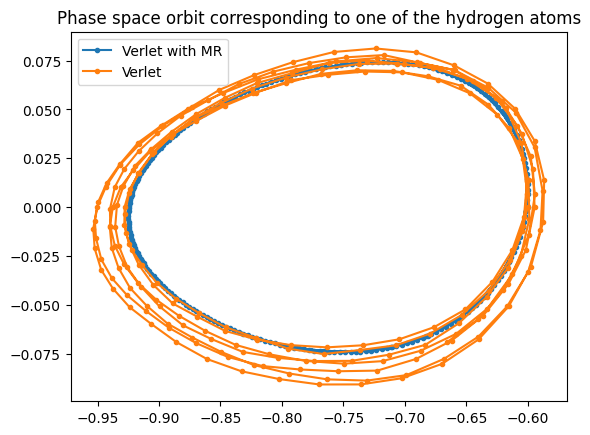

In [60]:
coords_mr_np = np.array(coords_mr)
momentum_mr_np = np.array(momentum_mr)
dist_mr = coords_mr_np[:,0]-coords_mr_np[:,1]
p_mr = momentum_mr_np[:,0]

coords_verlet_np = np.array(coords_verlet)
momentum_verlet_np = np.array(momentum_verlet)
dist_verlet = coords_verlet_np[:,0]-coords_verlet_np[:,1]
p_verlet = momentum_verlet_np[:,0]

plt.plot(dist_mr, p_mr, marker='.', label="Verlet with MR")
plt.plot(dist_verlet, p_verlet, marker='.', label="Verlet")
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.legend()
plt.show()

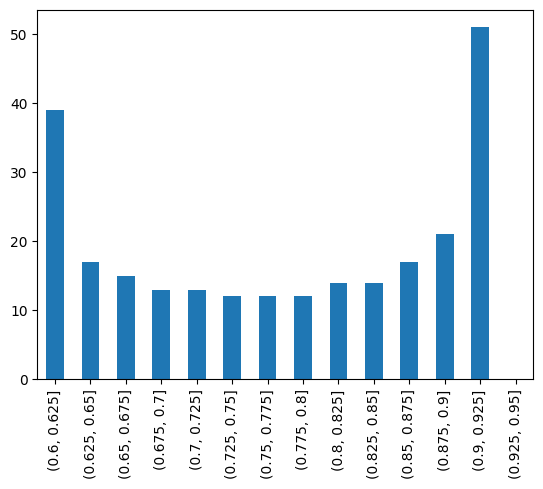

In [8]:
bins = np.linspace(0.6,0.95,15)
coords_mr_np = np.array(coords_mr)
dist_mr = coords_mr_np[:,1]-coords_mr_np[:,0]
prob_mr = pd.cut(dist_mr,bins)
mr=pd.value_counts(prob_mr).sort_index()

mr.plot.bar(align ='center')
plt.show()

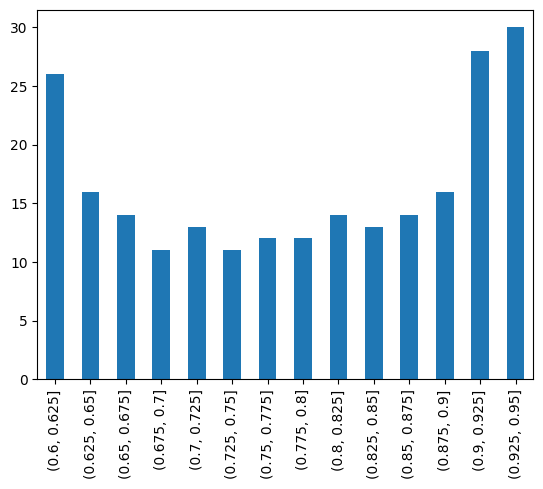

In [61]:
coords_verlet_np = np.array(coords_verlet)
dist_verlet = coords_verlet_np[:,1]-coords_verlet_np[:,0]
prob_verlet = pd.cut(dist_verlet,bins)
verlet=pd.value_counts(prob_verlet).sort_index()

verlet.plot.bar(align ='center')
plt.show()

In [49]:
#canonical
from tqdm import tqdm #to show progress

femto = 1.0e-15
angst = 1.0e-10
u = 1.67e-27
#mass of particle1 (H)
mass_0 = u
#mass of particle2 (H)
mass_1 = u
mass = [mass_0, mass_1]
#time step of integrator
dt = 0.2*femto
#initial velocity of atoms
v_init = [0, 0]
#initial positions of atoms
init_pos = [0, 0.6]

#integrator timesteps
times = np.arange(0*femto, 50.0*femto, dt)

#k_B*T in Joule
k_B = 1.38065e-23
T = 420
k_T = k_B*T
#delta factor
delta = 2*dt

def canonical(init_pos, v_init=v_init, mass=mass, simulator='qasm', shots=256):
    coords = [init_pos]
    momentum = [[mass[0]/u*v_init[0]/angst*femto, mass[1]/u*v_init[1]/angst*femto]]
    force = []
    
    for time in tqdm(times, desc='Progress: '):
        r = coords[-1]
        if time == 0:
            (forces,COV,pauli_op_array,_) = calc_force_and_cov(coords[-1], shots=shots)
            f0 = forces[0]
            f1 = forces[1]
            v_next = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_init)/shots*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt      
            r_next = (np.array(r)*angst + dt*v_next)/angst

        else:
            (forces,COV,_,_) = calc_force_and_cov(coords[-1],PauliArray=pauli_op_array, shots=shots)
            f0 = forces[0]
            f1 = forces[1]          
            v_next += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_next)/shots*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt
            r_next = (np.array(r)*angst + dt*v_next)/angst

        coords.append([r_next[0], r_next[1]])
        momentum.append([mass[0]/u*v_next[0]/angst*femto, mass[1]/u*v_next[1]/angst*femto])
    
    return coords, momentum

# can combine the two function canonical and canonical_diag to cost less time.

def canonical_diag(init_pos, v_init=v_init, mass=mass, simulator='qasm', shots=256):
    coords = [init_pos]
    momentum = [[mass[0]/u*v_init[0]/angst*femto, mass[1]/u*v_init[1]/angst*femto]]
    force = []
    
    for time in tqdm(times, desc='Progress: '):
        r = coords[-1]
        if time == 0:
            (forces,_,pauli_op_array,COV_diag) = calc_force_and_cov(coords[-1], shots=shots)
            f0 = forces[0]
            f1 = forces[1]
            v_next = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV_diag,v_init)/shots*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt      
            r_next = (np.array(r)*angst + dt*v_next)/angst

        else:
            (forces,_,_,COV_diag) = calc_force_and_cov(coords[-1],PauliArray=pauli_op_array, shots=shots)
            f0 = forces[0]
            f1 = forces[1]          
            v_next += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV_diag,v_next)/shots*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt
            r_next = (np.array(r)*angst + dt*v_next)/angst

        coords.append([r_next[0], r_next[1]])
        momentum.append([mass[0]/u*v_next[0]/angst*femto, mass[1]/u*v_next[1]/angst*femto])
    
    return coords, momentum

In [34]:
(coords_langevin, momentum_langevin) = canonical(init_pos=init_pos, shots=512)

Progress: 100%|███████████████████████████████████████████████████████████████████████| 250/250 [56:30<00:00, 13.56s/it]


In [50]:
(coords_langevin_diag, momentum_langevin_diag) = canonical_diag(init_pos=init_pos, shots=512)

Progress: 100%|███████████████████████████████████████████████████████████████████████| 250/250 [59:42<00:00, 14.33s/it]


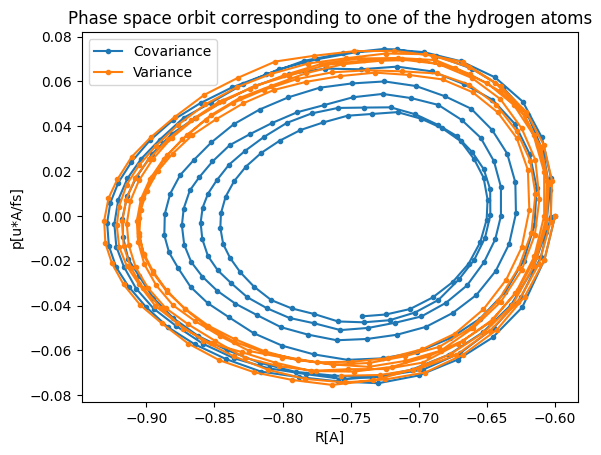

In [57]:
coords_langevin_np = np.array(coords_langevin)
momentum_langevin_np = np.array(momentum_langevin)
dist_langevin = coords_langevin_np[:,0]-coords_langevin_np[:,1]
p_langevin = momentum_langevin_np[:,0]

coords_langevin_diag_np = np.array(coords_langevin_diag)
momentum_langevin_diag_np = np.array(momentum_langevin_diag)
dist_langevin_diag = coords_langevin_diag_np[:,0]-coords_langevin_diag_np[:,1]
p_langevin_diag = momentum_langevin_diag_np[:,0]

plt.plot(dist_langevin, p_langevin, marker='.', label="Covariance")
plt.plot(dist_langevin_diag, p_langevin_diag, marker='.', label="Variance")
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*A/fs]")
plt.legend()
plt.show()

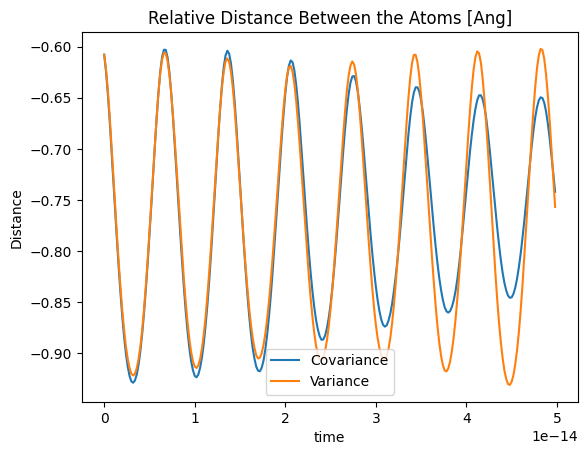

In [58]:
rel_dist_langevin = coords_langevin_np[1:,0] - coords_langevin_np[1:,1]
rel_dist_langevin_diag = coords_langevin_diag_np[1:,0] - coords_langevin_diag_np[1:,1]
plt.plot(times,rel_dist_langevin, label="Covariance")
plt.plot(times,rel_dist_langevin_diag, label="Variance")
plt.title('Relative Distance Between the Atoms [Ang]')
plt.xlabel("time")
plt.ylabel("Distance")
plt.legend()
plt.show()

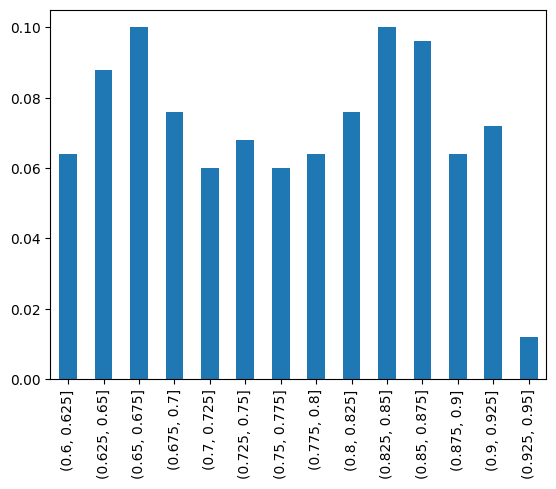

In [36]:
bins = np.linspace(0.6,0.95,15)
coords_langevin_np = np.array(coords_langevin)
dist_langevin = coords_langevin_np[:,1]-coords_langevin_np[:,0]
prob_langevin = pd.cut(dist_langevin,bins)
langevin=pd.value_counts(prob_langevin, normalize=True).sort_index()

langevin.plot.bar(align ='center')
plt.show()

In [62]:
kin_eng = (momentum_langevin_np[:,0]*u*angst/femto)**2/(2*mass_0)

In [63]:
2*np.mean(kin_eng)/k_B

2276.7106005306723

In [64]:
2*np.std(kin_eng)/k_B

1907.1524730389056